In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math

from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, RBF, DotProduct, RationalQuadratic

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5



rmsle_scorer = make_scorer(rmsle, greater_is_better=False)


# functions by https://www.kaggle.com/masayukixhirose/house-prices-advanced-regression-techniques/linear-model-roughly-modeling
def catcheck(df):
    iscat = np.zeros(df.shape[1])
    for c in range(df.shape[1]):
        if df.dtypes[c] == 'object':
            iscat[c] = 1
        else:
            iscat[c] = 0
    catdf = pd.DataFrame({'variable': df.columns, 'iscat': iscat})
    havecat = catdf[catdf.iscat == 1]
    catcolumn = havecat.variable.tolist()
    return catcolumn  
#     return df.dtypes[df.dtypes == "object"].index


def NAcheck(df):
    isna = np.zeros(df.shape[1])
    for c in range(df.shape[1]):
        isna[c] = df.iloc[:, c].isnull().values.any()
            # For each columns, it return "True" if they have NaN.
    nandf = pd.DataFrame({'variable': df.columns, 'isna': isna})
    havenan = nandf[nandf.isna == 1]
    NAcolumn = havenan.variable.tolist()
    return NAcolumn




data_description.webarchive
sample_submission.csv
test.csv
train.csv



In [7]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
y_log = np.log1p(train["SalePrice"].values)
train1 = train.drop(["Id","SalePrice"], axis=1)
test1 = test.drop("Id", axis=1)

collist = set(NAcheck(train1) + NAcheck(test1))
train1 = train1.drop(collist, axis = 1)
test1 = test1.drop(collist, axis = 1)


train1 = train1.drop(catcheck(train1), axis = 1)
test1 = test1.drop(catcheck(test1), axis = 1)

print(train1.columns)

X = train1.values
X_test = test1.values



Index([u'MSSubClass', u'LotArea', u'OverallQual', u'OverallCond', u'YearBuilt',
       u'YearRemodAdd', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'TotRmsAbvGrd', u'Fireplaces', u'WoodDeckSF',
       u'OpenPorchSF', u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch',
       u'PoolArea', u'MiscVal', u'MoSold', u'YrSold'],
      dtype='object')


In [8]:
#kernel = 1*RBF(length_scale=1.0)
kernel = 1.0**2 * Matern(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0), nu=0.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=5e-9, optimizer='fmin_l_bfgs_b', 
                                n_restarts_optimizer=0, normalize_y=False, copy_X_train=True,
                                random_state=2016)
clf = Pipeline([('scaler', StandardScaler()), ('gp', gp)])     
y_log_centered = y_log - y_log.mean()
y_pred = cross_val_predict(clf, X, y_log_centered, cv=5, n_jobs=-1)
y = np.expm1(y_log)
y_pred = np.expm1(y_pred + y_log.mean())
score = rmsle(y,y_pred)

print(score) # 0.1459

mse = np.sqrt(mean_squared_error(y, y_pred))
print mse

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag

0.145949686577
32135.8784235


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


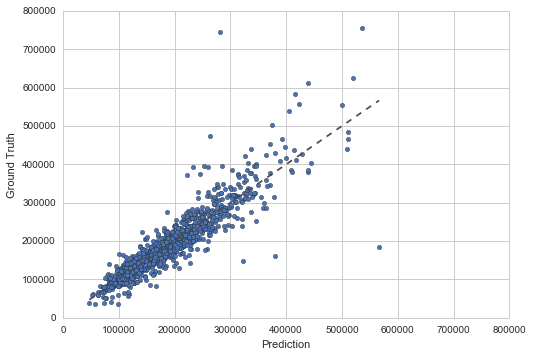

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

plt.scatter(y_pred, y)
plt.plot([min(y_pred),max(y_pred)], [min(y_pred),max(y_pred)], ls="--", c=".3")
plt.xlim([0,800000])
plt.ylim([0,800000])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.show()



In [6]:
# predict
clf.fit(X,y_log_centered)
prediction = clf.predict(X_test)
print(clf.steps[1][1].kernel_)
prediction = np.expm1(prediction + y_log.mean())
def write_to_csv(output,score):
    import datetime
    import csv
    now = datetime.datetime.now()
    sub_file = 'submission_' + str(score) + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    print('Writing submission: ', sub_file)
    f = open(sub_file, 'w')
    prediction_file_object = csv.writer(f)
    prediction_file_object.writerow(["Id","SalePrice"])  # don't forget the headers

    for i in range(len(test)):
        prediction_file_object.writerow([test["Id"][test.index[i]], (output[i])])

        
write_to_csv(prediction, score)




/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.03259475, -0.06916236]), 'nit': 14, 'funcalls': 72}
  " state: %s" % convergence_dict)


1.38**2 * Matern(length_scale=198, nu=0.5)
('Writing submission: ', 'submission_0.145949686577_2016-10-29-21-15.csv')
